<h1 style="text-align: center;">Определение стоимостей автомобилей</h1>

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 

Необходимо построить модель, которая умеет определять стоимость авто. Имеются данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

# Описание данных
Датасет: `/datasets/autos.csv`

Признак          | Описание                                        | Ед. измерения
-----------------|-------------------------------------------------|---------------
DateCrawled      | дата скачивания анкеты из базы                  |
VehicleType      | тип автомобильного кузова                       |
RegistrationYear | год регистрации автомобиля                      |
Gearbox          | тип коробки передач                             |
Power            | мощность                                        | л.с.
Model            | модель автомобиля                               |           
Kilometer        | пробег                                          | км
RegistrationMonth| месяц регистрации автомобиля                    |
FuelType         | тип топлива                                     |
Brand            | марка автомобиля                                |
Repaired         | была машина в ремонте или нет                   |
DateCreated      | дата создания анкеты                            |
NumberOfPictures | количество фотографий автомобиля                |
PostalCode       | почтовый индекс владельца анкеты (пользователя) |
LastSeen         | дата последней активности пользователя          |
**Price**        | цена                                            | евро

# Импорт необходимых библиотек

In [1]:
pip install -q --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -q phik

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -q shap

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install -q lightgbm

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik
import shap
from sklearn import tree

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder, 
    StandardScaler, 
    OrdinalEncoder, 
    MinMaxScaler, 
    LabelEncoder
)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import recall_score, precision_score

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# импортируем модель
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR

from sklearn.inspection import permutation_importance

from lightgbm import LGBMRegressor

## Константы

In [6]:
# задаём размер тестовой выборки и random_state
RANDOM_STATE = 42

# train - 80%
# valid - 10%
# test - 10%
TEST_SIZE = 0.20

# Загрузка данных

In [7]:
try:

    df = pd.read_csv('./datasets/autos.csv')

except:
    df = pd.read_csv('/datasets/autos.csv')

In [8]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Данные успешно загружены. Переименуем столбцы, приведём их названия к snake_case.

In [9]:
df.columns = (df.columns
                .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                .str.lower()
             )
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Столбцы успешно переименованы.

# Предобработка данных

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

Преобразуем столбцы с типом int64 в int

In [11]:
int_columns = ['price', 'registration_year', 'power', 'kilometer', 'registration_month', 'number_of_pictures', 'postal_code']

for col in int_columns:
    df[col] = df[col].astype('int32')

Преобразуем столбцы с датами в соответствующий тип datetime.

In [12]:
datetime_columns = ['date_crawled', 'date_created', 'last_seen']

for col in datetime_columns:
    df[col] = pd.to_datetime(df[col])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int32         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int32         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int32         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int32         
 8   registration_month  354369 non-null  int32         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

Все типы данных успешно приведены к порядок.

Наблюдаем пропуски в столбцах: vehicle_type, gearbox, model, fuel_type, repaired. Все столбцы с пропусками категориальные. Посмотрим сколько пропусков в каждом столбце.

In [19]:
for col in ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']:
    nan_count = df[col].isna().sum()
    print(f'Column: {col}   NaN count: {nan_count}   NaN prop: {round(nan_count/df.shape[0], 2)}')

Column: vehicle_type   NaN count: 37490   NaN prop: 0.11
Column: gearbox   NaN count: 19833   NaN prop: 0.06
Column: model   NaN count: 19705   NaN prop: 0.06
Column: fuel_type   NaN count: 32895   NaN prop: 0.09
Column: repaired   NaN count: 71154   NaN prop: 0.2


Попуски составляют от 6 до 20% объема всех данных. Больше всего пропусков в столбце repaired. Так как признак model один из самых важных, пропуски по данному признаку удалим из рассмотрения.

In [20]:
df = df.dropna(subset=['model'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334664 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        334664 non-null  datetime64[ns]
 1   price               334664 non-null  int32         
 2   vehicle_type        304002 non-null  object        
 3   registration_year   334664 non-null  int32         
 4   gearbox             318962 non-null  object        
 5   power               334664 non-null  int32         
 6   model               334664 non-null  object        
 7   kilometer           334664 non-null  int32         
 8   registration_month  334664 non-null  int32         
 9   fuel_type           308932 non-null  object        
 10  brand               334664 non-null  object        
 11  repaired            272564 non-null  object        
 12  date_created        334664 non-null  datetime64[ns]
 13  number_of_pictures  334664 no

Пропуски по признаку model устранены. Для толбцов vehicle_type, gearbox, fuel_type пропуски составляют менее 10%, заполним их модой (самым популярным значением) в будущем в пайплайне.

Пропуски в столбце repaired оставим без изменений, поскольку их достаточно много. Возможно отсутствие информации о том, была ли машина в ремонте, влияет на стоимость.

Признаки registration_month и postal_code неинформативные, уберём их из рассмотрения.

In [21]:
df = df.drop(columns=['registration_month', 'postal_code'])

Поищем дубликаты в данных.

In [22]:
df.duplicated().sum()

5

В данных обнаружены явные дубликаты, уберём их из рассмотрения.

In [23]:
df = df.drop_duplicates()

In [24]:
cat_cols = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

for col in cat_cols:
    print(f'Column: {col} Unique: {df[col].unique()}')

Column: vehicle_type Unique: [nan 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'coupe' 'other']
Column: gearbox Unique: ['manual' 'auto' nan]
Column: model Unique: ['golf' 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe' 'passat'
 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er' 'meriva'
 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio' 'kadett'
 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum' 'astra' 'a8'
 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156' 'escort'
 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo' 'focus' 'tt'
 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe' 'sportage'
 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3' 'almera'
 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' '

Проверим наличие дубликатов в списке моделей.

In [25]:
uniq, counts = np.unique(df['model'].unique(), return_counts=True)
dict(zip(uniq, counts))

{'100': 1,
 '145': 1,
 '147': 1,
 '156': 1,
 '159': 1,
 '1_reihe': 1,
 '1er': 1,
 '200': 1,
 '2_reihe': 1,
 '300c': 1,
 '3_reihe': 1,
 '3er': 1,
 '4_reihe': 1,
 '500': 1,
 '5_reihe': 1,
 '5er': 1,
 '601': 1,
 '6_reihe': 1,
 '6er': 1,
 '7er': 1,
 '80': 1,
 '850': 1,
 '90': 1,
 '900': 1,
 '9000': 1,
 '911': 1,
 'a1': 1,
 'a2': 1,
 'a3': 1,
 'a4': 1,
 'a5': 1,
 'a6': 1,
 'a8': 1,
 'a_klasse': 1,
 'accord': 1,
 'agila': 1,
 'alhambra': 1,
 'almera': 1,
 'altea': 1,
 'amarok': 1,
 'antara': 1,
 'arosa': 1,
 'astra': 1,
 'auris': 1,
 'avensis': 1,
 'aveo': 1,
 'aygo': 1,
 'b_klasse': 1,
 'b_max': 1,
 'beetle': 1,
 'berlingo': 1,
 'bora': 1,
 'boxster': 1,
 'bravo': 1,
 'c1': 1,
 'c2': 1,
 'c3': 1,
 'c4': 1,
 'c5': 1,
 'c_klasse': 1,
 'c_max': 1,
 'c_reihe': 1,
 'caddy': 1,
 'calibra': 1,
 'captiva': 1,
 'carisma': 1,
 'carnival': 1,
 'cayenne': 1,
 'cc': 1,
 'ceed': 1,
 'charade': 1,
 'cherokee': 1,
 'citigo': 1,
 'civic': 1,
 'cl': 1,
 'clio': 1,
 'clk': 1,
 'clubman': 1,
 'colt': 1,
 'comb

Наблюдаем один неявный дубликат: 'petrol' и 'gasoline' - это название одного и того же типа топлива в разных странах. Исправим данную ситуацию и снова приверим наличие явных дубликатов.

Для всех численных признаков посмотрим наличие выбросов.

In [26]:
df['fuel_type'] = df['fuel_type'].replace('gasoline', 'petrol')
df['fuel_type'].unique()

array(['petrol', nan, 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

In [27]:
df.duplicated().sum()

0

In [28]:
def print_boxplot(df, column, title, x):
    '''
        Функция строит ящих с усами для отдельного столбца таблицы.
    '''
    fig = plt.figure(figsize=(7,2))
    plt.boxplot(df[column], vert=False)
    plt.title(title)
    plt.xlabel(x)
    plt.yticks([])
    plt.show();

In [29]:
num_cols = df.select_dtypes(include='number').columns.tolist()
num_cols

['price', 'registration_year', 'power', 'kilometer', 'number_of_pictures']

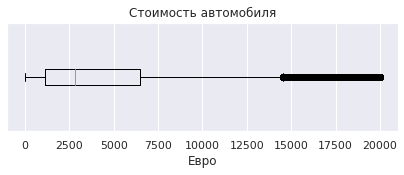

In [30]:
print_boxplot(df, 'price', 'Стоимость автомобиля', 'Евро')

Видим, что стоимость автомобиля колеблется от 0 до 20к евро. Среднее равняется приблизительно 2500 евро. Значения выше 13к евро считаются выбросами, ознако не смотря на свою редкость, удалять их из рассмотрения не будем.

In [31]:
df['registration_year'].describe()

count    334659.000000
mean       2003.923997
std          69.377734
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

Посмотрим на даты создания анкет.

In [32]:
df['date_created'].sort_values()

61207    2014-03-10
4001     2015-03-20
342275   2015-06-18
86601    2015-08-07
175103   2015-08-10
            ...    
216128   2016-04-07
285200   2016-04-07
292174   2016-04-07
206571   2016-04-07
124250   2016-04-07
Name: date_created, Length: 334659, dtype: datetime64[ns]

Самая поздняя дата скачивания датируется 2016 годом, что означает, что более поздний год регистрации авто будем считать ошибкой.

По описанию признака registration_year видим, что его значения колеблются от 1000 до 9999. Однако благодаря интернету можно выяснить, что год изобретения автомобиля - 1886. Значит значения в данном признаке могут находится только в диапазоне от 1886 до 2016. Посмотрим сколько в данных записей вне указанного диапазона.

In [33]:
df[(df['registration_year'] < 1886) | (df['registration_year'] > 2016)].shape[0]

12516

In [34]:
df[(df['registration_year'] < 1886) | (df['registration_year'] > 2016)].shape[0] / df.shape[0]

0.03739926313052988

Всего около 3% записей с нелогично указанным годом. Удалим их из рассмотрения и передадим информацию разработчикам о том, что данное поле иногда заполняется неверно. Тем не менее самостоятельно выяснить причину появления нелогичных данных мы не можем.

In [35]:
df = df[(df['registration_year'] >= 1886) & (df['registration_year'] <= 2016)]

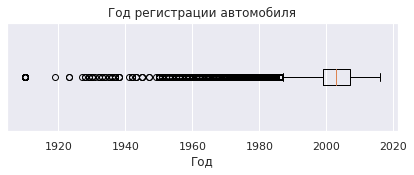

In [36]:
print_boxplot(df, 'registration_year', 'Год регистрации автомобиля', 'Год')

После исключения аномалий наблюдаем, что год регистрации принимает значения от 1910 до 2016. Среднее значение около 2003 года. Значения меньше 1985 года более редкие, однако имеют право на существование.

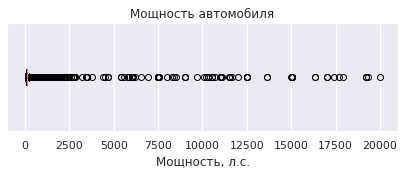

In [37]:
print_boxplot(df, 'power', 'Мощность автомобиля', 'Мощность, л.с.')

Самый мощный двигатель внутреннего сгорания (ДВС) в мире выдаёт 122 320 лошадиных сил. Среди автомобилей с высокой мощностью можно выделить, например:
- Koenigsegg Gemera — 2300 л. с.
- Lotus Evija — 1972 л. с.
- Pininfarina Battista — 1900 л. с.
- Hennessey Venom F5 — 1817 л. с.

Также по данным сайта quto.ru, средняя мощность автомобиля в 2022 году составляла 212 л.с. Посмотрим сколько в данных записей с мощностью выше 300 л.с.

In [38]:
df[df['power'] > 300].shape[0]

3063

Вероятнее всего причина таких больших значений в данном столбце - лишние нули в записи. Однако точная причина нам неизвестна. Передадим информацию разработчикам. 3000 записей составляют менее 1% объема данных, поэтому просто уберём их из рассмотрения.

In [39]:
df = df[df['power'] <= 300]

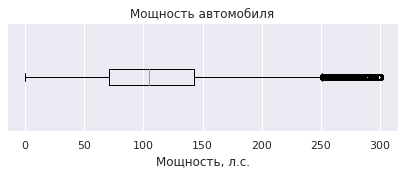

In [40]:
print_boxplot(df, 'power', 'Мощность автомобиля', 'Мощность, л.с.')

После преобразования наблюдаем, что значения колеблются от 0 до 250 л.с., среднее около 100 л.с., значения выше 250 л.с. считаются выбросами, однако могут быть реальными.

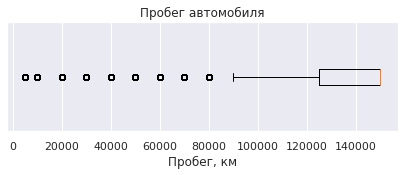

In [41]:
print_boxplot(df, 'kilometer', 'Пробег автомобиля', 'Пробег, км')

Наблюдаем выбросы - значения ниже 90к км. Посмотрим сколько таких записей.

In [42]:
df[df['kilometer'] < 90000].shape[0]

47809

Подобных значений достаточно много, очевидно, что автомобили с низким пробегом просто напросто новые. Ничего делать с данными выбросами не будем.

In [43]:
df['number_of_pictures'].describe()

count    319080.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: number_of_pictures, dtype: float64

В столбце number_of_pictures наблюдаем одни нули - то есть полное отсутствие информации. Передадим информацию разработчикам и уберём признак из рассмотрения как неинформативный.

In [44]:
df = df.drop(columns='number_of_pictures')

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319080 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date_crawled       319080 non-null  datetime64[ns]
 1   price              319080 non-null  int32         
 2   vehicle_type       301006 non-null  object        
 3   registration_year  319080 non-null  int32         
 4   gearbox            304892 non-null  object        
 5   power              319080 non-null  int32         
 6   model              319080 non-null  object        
 7   kilometer          319080 non-null  int32         
 8   fuel_type          298043 non-null  object        
 9   brand              319080 non-null  object        
 10  repaired           262801 non-null  object        
 11  date_created       319080 non-null  datetime64[ns]
 12  last_seen          319080 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int32(4), object(6)
me

## Промежуточные выводы

- Удалены из рассмотрения следующие неинформативные признаки: registration_month, postal_code, number_of_pictures
- Удалены 5 явных дубликатов
- Неявных дубликатов не обнаружено
- Удалены записи с пропусками в признаке model
- Замечены пропуски в столбцах vehicle_type, gearbox, fuel_type и repaired
- Имеются записи с аномальными значениями года регистрации авто
- Удалены 96 записей с годом не входящим в диапазон от 1886 до 2025
- Имеются записи с аномальными значениями мощности автомобиля
- Удалены 3140 записей с мощностью более 300 л.с.

# Создание новых признаков

Проанализируем даты скачивания, создания анкеты и последней активности пользователя.

In [46]:
df['date_crawled'].sort_values()

329497   2016-03-05 14:06:22
220583   2016-03-05 14:06:23
324763   2016-03-05 14:06:24
176823   2016-03-05 14:06:24
220604   2016-03-05 14:06:25
                 ...        
204218   2016-04-07 14:36:53
53739    2016-04-07 14:36:54
301030   2016-04-07 14:36:55
339649   2016-04-07 14:36:56
90713    2016-04-07 14:36:58
Name: date_crawled, Length: 319080, dtype: datetime64[ns]

Анкеты скачивались два раза, в даты 5 марта и 7 апреля 2016 года.

In [47]:
df['date_created'].sort_values()

61207    2014-03-10
4001     2015-03-20
342275   2015-06-18
86601    2015-08-07
175103   2015-08-10
            ...    
151050   2016-04-07
112857   2016-04-07
313630   2016-04-07
76295    2016-04-07
25931    2016-04-07
Name: date_created, Length: 319080, dtype: datetime64[ns]

Анкеты были созданы в период с 2014-03-10 по 2016-04-07.

In [48]:
df['last_seen'].sort_values()

296785   2016-03-05 14:15:08
262341   2016-03-05 14:15:16
130462   2016-03-05 14:15:39
285695   2016-03-05 14:18:30
169065   2016-03-05 14:25:59
                 ...        
290312   2016-04-07 14:58:50
219959   2016-04-07 14:58:50
68870    2016-04-07 14:58:50
235901   2016-04-07 14:58:50
327303   2016-04-07 14:58:51
Name: last_seen, Length: 319080, dtype: datetime64[ns]

Последняя активность пользователей была зафиксирована в период с 5 марта по 7 апреля 2016 года.

Из даты скачивания анкеты из базы и даты создания анкеты **создадим новые признаки**:
- год создания анкеты - created_year
- часов с момента создания до скачивания - existence_hours

Из даты оследней активности пользователя создадим новый признак:
- часов с момента создания анкеты до последней активности - active_hours

In [49]:
df['created_year'] = df['date_created'].apply(lambda x: x.year)

In [50]:
def existence(row):
    crawled = row['date_crawled']
    created = row['date_created']
    return round((crawled - created).total_seconds() / 3600)

df['existence_hours'] = df.apply(existence, axis=1)

In [51]:
df['existence_hours'].describe()

count    319080.000000
mean         17.983242
std          52.851594
min           0.000000
25%          13.000000
50%          17.000000
75%          21.000000
max       17700.000000
Name: existence_hours, dtype: float64

До момента скачивания анкеты просуществовали от 0 часов до 737 дней. В среднем время существования составило 18 часов.

In [52]:
def active_time(row):
    created = row['date_created']
    last_seen = row['last_seen']
    return round((last_seen - created).total_seconds() / 3600)

df['active_hours'] = df.apply(active_time, axis=1)

In [53]:
df['active_hours'].describe()

count    319080.000000
mean        222.296220
std         207.459618
min           1.000000
25%          61.000000
50%         156.000000
75%         336.000000
max       18221.000000
Name: active_hours, dtype: float64

С момента создания анкеты до последней активности прошло от 0 до 759 дней. В среднем 221 час или 9 дней.

## Корреляционный анализ

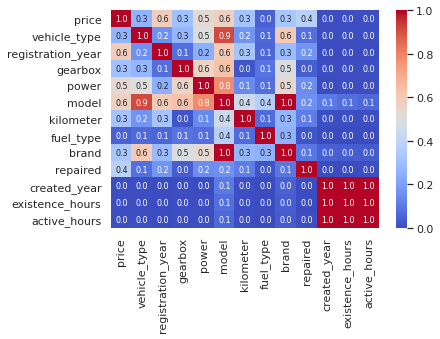

In [54]:
#исключим столбцы с датами из рассмотрения
df_corr = df[['price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'fuel_type', 'brand', 'repaired',
       'created_year', 'existence_hours', 'active_hours']]

num_columns = df_corr.select_dtypes(include='number').columns.tolist()
phik_corr = df_corr.phik_matrix(interval_cols=num_columns)
sns.heatmap(phik_corr,
            xticklabels=phik_corr.columns.values,
            yticklabels=phik_corr.columns.values,
            cmap='coolwarm',
            annot_kws={"fontsize":8},
            fmt=".1f",
            annot=True);

Целевой признак price сильнее всего коррелирует с годом регистрации, моделью и мощностью двигателя. 

Также отметим довольно сильную корреляцию между моделью и типом кузова, что вполне логично.

Среди других признаков замечаем мультиколлинеарность - бренд напрямую зависит от модели. Удалим признак бренд из рассмотрения. Также заметим что часы активности напрямую коррелируют с временем существования анкеты, а также годом создания анкеты. Также удалим некоторые из данных признаков из рассмотрения.

In [55]:
df = df.drop(columns=['brand', 'created_year', 'existence_hours'])

# Подготовка выборок для обучения моделей

Разделим данные на тренировочную и тестовую выборки.

In [62]:
X = df.drop(columns=['price', 'date_crawled', 'date_created', 'last_seen'])
y = df['price']

X_train, X_valid_test, y_train, y_valid_test = train_test_split(
    X, y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE
)

# валидационно-тестовую выборку поделим пополам на валидационную и тестовую
X_valid, X_test, y_valid, y_test = train_test_split(
    X_valid_test, y_valid_test,
    test_size = 0.5, 
    random_state = RANDOM_STATE
)

Сначала обозначим, какие признаки требуют кодирования, а какие масштабирования. Также обратим внимание, что пропуски в разных столбцах будем заполнять по-разному.

Для признаков vehicle_type, gearbox, fuel_type заполним пропуски модой (самым часто встрачаемым значением). Для признака repaired заполним пропуск значением 'unknown', то есть неизвестно. Тем же значением будем заполнять пропуски по признакам model и brand, если они появятся в будущем на новых данных. Так как данные признаки одни из самых важных, мы не можем заполнять пропуски модой.

Также отметим, что в данных отсутствуют порядковые признаки.

In [63]:
ohe_columns_mode = [
    'vehicle_type',
    'gearbox',
    'fuel_type'
]

ohe_columns_value = ['repaired', 'model']

num_columns = X.select_dtypes(include='number').columns.tolist()

Добавляем OHE-кодирование в пайплайны. 

In [64]:
# SimpleImputer + OHE
# Added in version 1.2: sparse was renamed to sparse_output.
ohe_pipe_mode = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

ohe_pipe_value = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

Объединяем шаги подготовки. Объединим кодирование и масштабирование в один пайплайн с подготовкой данных.

In [65]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe_mode', ohe_pipe_mode, ohe_columns_mode),
        ('ohe_value', ohe_pipe_value, ohe_columns_value),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [66]:
X_train = pd.DataFrame(
    data_preprocessor.fit_transform(X_train),
    columns=data_preprocessor.get_feature_names_out()
)

X_valid = pd.DataFrame(
    data_preprocessor.transform(X_valid),
    columns=data_preprocessor.get_feature_names_out()
)

X_test = pd.DataFrame(
    data_preprocessor.transform(X_test),
    columns=data_preprocessor.get_feature_names_out()    
) 

Данные подготовлены, приступим к обучению моделей.

# Обучение моделей

## LinearRegression

Для оценки качества моделей будем применять метрику **RMSE**. Успехом будет считаться RMSE < 2500.

In [67]:
model1 = LinearRegression(n_jobs=-1)

In [68]:
%%time
# обучаем модель на тренировочной выборке
model1.fit(X_train, y_train)

CPU times: user 11.6 s, sys: 2.83 s, total: 14.4 s
Wall time: 14.4 s


LinearRegression(n_jobs=-1)

In [69]:
%%time
# выводим предсказанные значения валидационной выборки
y_pred = model1.predict(X_valid)

CPU times: user 39 ms, sys: 55.9 ms, total: 94.8 ms
Wall time: 96.1 ms


In [70]:
score = root_mean_squared_error(y_valid, y_pred)
print(f'Model 1: RMSE на валидационной выборке: {round(score)}')

Model 1: RMSE на валидационной выборке: 2777


Для первой пробной подели получили значение RMSE = 2777, которое выходит за рамки критерия успеха. Попробуем изменить параметры.

## LGBMRegressor

Попробуем другие модели, на этот раз используем градиентный бустинг.

In [71]:
model2 = LGBMRegressor(
    n_estimators=100,
    max_depth=-1
)

In [72]:
%%time
model2.fit(X_train, y_train)

CPU times: user 6.97 s, sys: 183 ms, total: 7.15 s
Wall time: 7.09 s


LGBMRegressor()

In [73]:
%%time
# выводим предсказанные значения тестовой выборки
y_pred = model2.predict(X_valid)

score = root_mean_squared_error(y_valid, y_pred)
print(f'Model 3: RMSE на валидационной выборке: {round(score)}')

Model 3: RMSE на валидационной выборке: 1796
CPU times: user 390 ms, sys: 16.7 ms, total: 407 ms
Wall time: 403 ms


Градиентный бустинг отлично справился с задачей. Попробуем изменить параметры - увеличим количество используемых деревьев, установим глубину дерева.

In [74]:
model3 = LGBMRegressor(
    n_estimators=500,
    max_depth=10
)

In [75]:
%%time
model3.fit(X_train, y_train)

CPU times: user 20.9 s, sys: 200 ms, total: 21.1 s
Wall time: 21.1 s


LGBMRegressor(max_depth=10, n_estimators=500)

In [76]:
%%time
# выводим предсказанные значения тестовой выборки
y_pred = model3.predict(X_valid)

score = root_mean_squared_error(y_valid, y_pred)
print(f'Model 4: RMSE на валидационной выборке: {round(score)}')

Model 4: RMSE на валидационной выборке: 1690
CPU times: user 1.16 s, sys: 17.3 ms, total: 1.18 s
Wall time: 1.2 s


Выполим сравнение всех 3 моделей.

Параметр               | Model 1 | Model 2   | Model 3  
-----------------------|---------|-----------|----------
Тип модели             | LinReg  | LightGBM  | LightGBM 
Wall time обучения     | 14.2 s  | 15.6 s    | 19.4 s   
Wall time предсказания | 10.5 ms | 514 ms    | 1.19 s   
**RMSE на валидационной выборке** | 2777 | 1796 | 1690     

Обучается быстрее всего модель 1, предсказывает быстрее всего модель 1, лучший результат метрики - модель 3. Модель Линейной Регрессии заметно проигрывает LightGBM по качеству. 

У модели LightGBM при увеличении количества деревьев время обучения и предсказания возрастает.

Лучшая модель - model3, посмотрим на метрику на тестовой выборке.

In [77]:
%%time
# выводим предсказанные значения тестовой выборки
y_pred = model3.predict(X_test)

score = root_mean_squared_error(y_test, y_pred)
print(f'Model 4: RMSE на тестовой выборке: {round(score)}')

Model 4: RMSE на тестовой выборке: 1620
CPU times: user 1.21 s, sys: 11.2 ms, total: 1.22 s
Wall time: 1.29 s


Метрика на тестовой выборке стала даже ещё лучше, чем на валидационной.

# Итоговый вывод

Учитывая критерии заказчика логичным решением будет модель 3, которая сочитает в себе не высокое время обучения и предсказания при достаточно высоком уровне качества. В дальнейшем возможно обсуждение корректировки параметров модели для увеличения качества, при условии, что время работы модели будет увеличиваться.

Заказчику предлагается модель LightGBM со стандартными параметрами. Ошибка предсказания около ±1600 евро.

Разработчикам стоит обратить внимание на явные дубликаты строк, пропуски в поле model, аномальные значения в полях registration_year и power.